In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance.plotting as mpf
import seaborn as sns
import datetime
import re
import ccxt
import pickle
import talib
# pd.options.plotting.backend = "plotly"

In [2]:
df = pd.read_csv('dataset/cryptdownload/Binance_ETHUSDT_1h.csv')
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', ascending=True, inplace=True)
df.drop(columns=['symbol', 'tradecount'], inplace=True)
df

,time,base_volume,quote_volume,close,high,low,open
32620,2017-08-17 04:00:00,122.52000,3.673684e+04,300.79,652.74,298.00,652.74
32619,2017-08-17 05:00:00,377.67000,1.140433e+05,303.10,303.28,300.00,301.61
32618,2017-08-17 06:00:00,302.51000,9.162268e+04,302.68,304.44,301.90,303.10
32617,2017-08-17 07:00:00,753.19000,2.292483e+05,307.96,307.96,302.60,302.68
32616,2017-08-17 08:00:00,150.75000,4.655946e+04,308.62,309.97,307.00,307.96
...,...,...,...,...,...,...,...
4,2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59
3,2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17
2,2021-05-07 22:00:00,38829.22486,1.340210e+08,3443.00,3499.00,3421.11,3475.83
1,2021-05-07 23:00:00,19900.24004,6.908357e+07,3479.53,3489.00,3438.59,3442.19


<AxesSubplot:xlabel='time'>

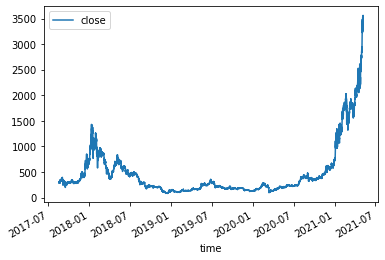

In [3]:
df.plot(x='time', y='close')

# Feature engineering

In [4]:
ORIGINAL_SIGNAL_COLUMNS = ['open', 'high', 'low', 'close']
SIGNAL_COLUMNS = ORIGINAL_SIGNAL_COLUMNS.copy()

## Create target column

In [5]:
target_column = 'close'
shifting_df = df[['time', 'close']].copy()
shifting_df['time'] = shifting_df['time'] - pd.Timedelta(hours=1)

last_datetime = df['time'].max() - pd.Timedelta(hours=1)
df = df[df['time'] <= last_datetime]

shifting_df.rename(columns={'close': 'next_close'}, inplace=True)
df = df.merge(shifting_df, how='left', on='time')

## Drop nan target 

In [6]:
df.isna().sum(axis=0)

time            0
base_volume     0
quote_volume    1
close           0
high            0
low             0
open            0
next_close      8
dtype: int64

In [7]:
df.dropna(subset=['next_close'], inplace=True)
df.isna().sum(axis=0)

time            0
base_volume     0
quote_volume    1
close           0
high            0
low             0
open            0
next_close      0
dtype: int64

## Add Technical Indicator

#### Moving Average

In [8]:
ma_df = df[['time', 'close']].copy()
ma_df['EMA30'] = talib.EMA(df['close'], timeperiod=30)
ma_df['EMA80'] = talib.EMA(df['close'], timeperiod=60)
ma_df

,time,close,EMA30,EMA80
0,2017-08-17 04:00:00,300.79,NaN,NaN
1,2017-08-17 05:00:00,303.10,NaN,NaN
2,2017-08-17 06:00:00,302.68,NaN,NaN
3,2017-08-17 07:00:00,307.96,NaN,NaN
4,2017-08-17 08:00:00,308.62,NaN,NaN
...,...,...,...,...
32615,2021-05-07 19:00:00,3512.59,3482.553027,3443.205732
32616,2021-05-07 20:00:00,3497.20,3483.497993,3444.976036
32617,2021-05-07 21:00:00,3475.89,3483.007155,3445.989609
32618,2021-05-07 22:00:00,3443.00,3480.426048,3445.891589


<AxesSubplot:xlabel='time'>

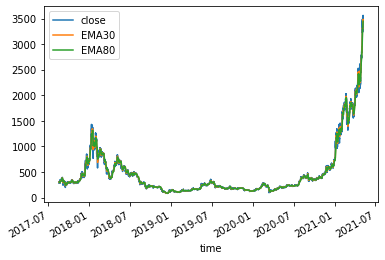

In [9]:
ma_df.plot(x='time', y=['close', 'EMA30', 'EMA80'])

In [10]:
ma_df.drop(columns=['time', 'close'], inplace=True)

#### Combine Technical Indicator

In [11]:
MA_COLUMNS = list(ma_df.columns)

SIGNAL_COLUMNS += MA_COLUMNS

df = pd.concat([df, ma_df], axis=1)

## Drop NaN Input

In [12]:
df.dropna(inplace=True)

## Generate past signal data

In [13]:
def generate_past_signal_data(df, lookback_steps):
    
    base_df = df[['time'] + SIGNAL_COLUMNS]
    
    first_datetime = df['time'].min() + pd.Timedelta(hours=max(lookback_steps))
    df = df[df['time'] >= first_datetime]
    for lookback_step in lookback_steps:
        shifting_df = base_df.copy()
        shifting_df['time'] = shifting_df['time'] + pd.Timedelta(hours=lookback_step)
        lookback_columns = [f'p{lookback_step}_{col}' for col in SIGNAL_COLUMNS]
        shifting_df.rename(columns=dict(zip(SIGNAL_COLUMNS, lookback_columns)), inplace=True)
        
        df = df.merge(shifting_df, how='left', on='time')
    return df

# lookback_steps = [0, 1, 2, 3, 4]
lookback_steps = np.arange(48)
df = generate_past_signal_data(df, lookback_steps)
df.set_index('time', inplace=True)

In [14]:
def get_by_lookback_step(df, lookback_step):
    return df.filter(regex=f'p{lookback_step}_')
def get_by_lookback_steps(df, lookback_steps):
    lookback_steps = list(map(str, lookback_steps))
    return df.filter(regex=f'p({"|".join(lookback_steps)})_')
def get_by_signal(df, signal_column):
    return df.filter(regex=f'p\d+_{signal_column}')
def get_only_signal(df):
    return df.filter(regex=f'p\d+_.')
# get_by_lookback_step(df, 1)
# get_by_signal(df, 'close')
get_only_signal(df)

,p0_open,p0_high,p0_low,p0_close,p0_EMA30,p0_EMA80,p1_open,p1_high,p1_low,p1_close,...,p46_low,p46_close,p46_EMA30,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,346.52,346.52,328.68,334.17,311.443307,305.330403,331.30,346.52,329.41,346.52,...,286.12,286.14,292.580657,299.342943,283.00,288.64,283.00,288.64,293.024840,299.790500
2017-08-21 15:00:00,334.17,338.34,329.47,334.94,312.959223,306.301209,346.52,346.52,328.68,334.17,...,284.16,293.15,292.617389,299.139895,288.64,290.16,286.12,286.14,292.580657,299.342943
2017-08-21 16:00:00,334.94,338.34,333.25,338.33,314.596047,307.351333,334.17,338.34,329.47,334.94,...,288.95,295.00,292.771105,299.004161,286.14,293.15,284.16,293.15,292.617389,299.139895
2017-08-21 17:00:00,338.33,342.72,330.80,332.33,315.740173,308.170306,334.94,338.34,333.25,338.33,...,291.99,293.31,292.805873,298.817467,293.15,295.00,288.95,295.00,292.771105,299.004161
2017-08-21 18:00:00,332.33,333.63,316.82,316.82,315.809839,308.453903,338.33,342.72,330.80,332.33,...,288.80,290.31,292.644849,298.538534,295.00,295.00,291.99,293.31,292.805873,298.817467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,3525.90,3533.76,3498.28,3512.59,3482.553027,3443.205732,3534.77,3538.14,3512.62,3526.06,...,3420.00,3426.36,3363.819507,3296.101146,3480.50,3484.88,3412.25,3459.32,3359.506370,3291.685592
2021-05-07 20:00:00,3512.59,3525.62,3476.04,3497.20,3483.497993,3444.976036,3525.90,3533.76,3498.28,3512.59,...,3426.02,3521.40,3373.985990,3303.487994,3459.06,3466.32,3420.00,3426.36,3363.819507,3296.101146
2021-05-07 21:00:00,3497.17,3497.80,3455.70,3475.89,3483.007155,3445.989609,3512.59,3525.62,3476.04,3497.20,...,3494.09,3524.26,3383.681088,3310.726420,3426.36,3537.13,3426.02,3521.40,3373.985990,3303.487994


## Normalize signal data

### Min-Max Close of Individual window

In [15]:
class MinMaxCloseWindowScaler:
    def fit(self, signal_df):
        self.min_close = get_by_signal(signal_df, 'close').min(axis=1)
        self.max_close = get_by_signal(signal_df, 'close').max(axis=1)
    def transform(self, signal_df):
        signal_df = signal_df.subtract(self.min_close, axis=0).div(self.max_close - self.min_close, axis=0)
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.min_close) / (self.max_close - self.min_close)
    def inverse_transform_target(self, target):
        return target * (self.max_close - self.min_close) + self.min_close


In [16]:
_df = df.copy()
signal_df = get_only_signal(_df)

min_max_close_window_scaler = MinMaxCloseWindowScaler()
_df[signal_df.columns] = min_max_close_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = min_max_close_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,EMA30,EMA80,p0_open,...,p46_close,p46_EMA30,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,362.71000,1.214923e+05,334.17,346.52,328.68,346.52,334.94,311.443307,305.330403,1.000000,...,0.000000,0.106669,0.218664,-0.052004,0.041404,-0.052004,0.041404,0.114025,0.226077,0.808215
2017-08-21 15:00:00,347.71000,1.160360e+05,334.94,338.34,329.47,334.17,338.33,312.959223,306.301209,0.795462,...,0.116098,0.107277,0.215301,0.041404,0.066578,-0.000331,0.000000,0.106669,0.218664,0.864359
2017-08-21 16:00:00,272.47000,9.125266e+04,338.33,338.34,333.25,334.94,332.33,314.596047,307.351333,0.805444,...,0.134409,0.096961,0.201683,-0.014449,0.103327,-0.047715,0.103327,0.094378,0.203963,0.761593
2017-08-21 17:00:00,505.26000,1.704932e+05,332.33,342.72,330.80,338.33,316.82,315.740173,308.170306,0.862399,...,0.106015,0.097545,0.198546,0.103327,0.134409,0.032762,0.134409,0.096961,0.201683,0.501008
2017-08-21 18:00:00,491.05000,1.606452e+05,316.82,333.63,316.82,332.33,329.71,315.809839,308.453903,0.761593,...,0.055612,0.094840,0.193860,0.134409,0.134409,0.083837,0.106015,0.097545,0.198546,0.717574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,3482.553027,3443.205732,0.791414,...,0.198702,-0.173696,-0.576925,0.521079,0.547160,0.114684,0.394962,-0.199379,-0.603218,0.620519
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,3483.497993,3444.976036,0.712159,...,0.764618,-0.113160,-0.532940,0.393414,0.436644,0.160831,0.198702,-0.173696,-0.576925,0.493629
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,3483.007155,3445.989609,0.620341,...,0.781648,-0.055430,-0.489839,0.198702,0.858283,0.196677,0.764618,-0.113160,-0.532940,0.297785


<AxesSubplot:>

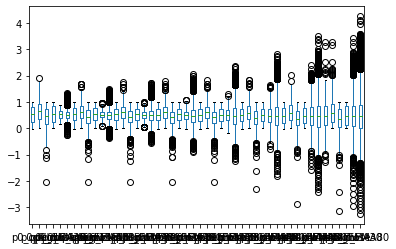

In [17]:
sampled_lookback_steps = np.linspace(0, max(lookback_steps), 8).astype(int)

get_by_lookback_steps(_df, sampled_lookback_steps).plot.box()

<AxesSubplot:>

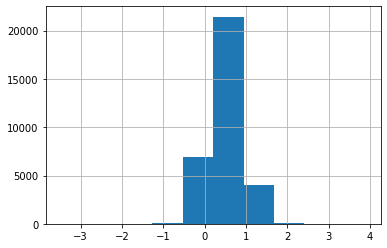

In [18]:
_df['norm_next_close'].hist()

<AxesSubplot:xlabel='p0_close', ylabel='norm_next_close'>

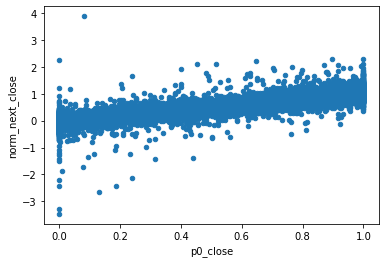

In [19]:
_df.plot(x='p0_close', y='norm_next_close', kind='scatter')

<AxesSubplot:>

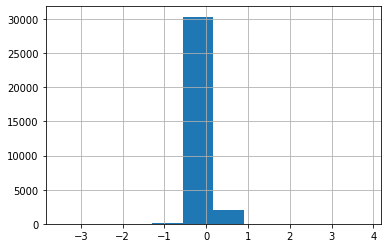

In [20]:
(_df['norm_next_close'] - _df['p0_close']).hist()

In [21]:
(_df['norm_next_close'] - _df['p0_close']).describe()

count    32505.000000
mean         0.001161
std          0.142020
min         -3.476744
25%         -0.056902
50%          0.001360
75%          0.060203
max          3.803987
dtype: float64

### Standardize Close of Individual Window

In [22]:
class StandardizeCloseWindowScaler:
    def fit(self, signal_df):
        self.mean = get_by_signal(signal_df, 'close').mean(axis=1)
        self.std = get_by_signal(signal_df, 'close').std(axis=1)
    def transform(self, signal_df):
        signal_df = signal_df.subtract(self.mean, axis=0).div(self.std, axis=0)
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.mean) / self.std
    def inverse_transform_target(self, target):
        return target * self.std + self.mean


In [23]:
_df = df.copy()
signal_df = get_only_signal(_df)

standardize_close_window_scaler = StandardizeCloseWindowScaler()
_df[signal_df.columns] = standardize_close_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = standardize_close_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,EMA30,EMA80,p0_open,...,p46_close,p46_EMA30,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,362.71000,1.214923e+05,334.17,346.52,328.68,346.52,334.94,311.443307,305.330403,3.276321,...,-1.072979,-0.609044,-0.121943,-1.299159,-0.892898,-1.299159,-0.892898,-0.577049,-0.089704,2.442189
2017-08-21 15:00:00,347.71000,1.160360e+05,334.94,338.34,329.47,334.17,338.33,312.959223,306.301209,2.204394,...,-0.606468,-0.642964,-0.196015,-0.915512,-0.811355,-1.088193,-1.086822,-0.645481,-0.182101,2.489455
2017-08-21 16:00:00,272.47000,9.125266e+04,338.33,338.34,333.25,334.94,332.33,314.596047,307.351333,2.080077,...,-0.528158,-0.673714,-0.266671,-1.106750,-0.648970,-1.236052,-0.648970,-0.683752,-0.257807,1.909634
2017-08-21 17:00:00,505.26000,1.704932e+05,332.33,342.72,330.80,338.33,316.82,315.740173,308.170306,2.177724,...,-0.670153,-0.702043,-0.321761,-0.680274,-0.563247,-0.945958,-0.563247,-0.704242,-0.309952,0.817043
2017-08-21 18:00:00,491.05000,1.606452e+05,316.82,333.63,316.82,332.33,329.71,315.809839,308.453903,1.763601,...,-0.885761,-0.738549,-0.366952,-0.590056,-0.590056,-0.779837,-0.696611,-0.728396,-0.349365,1.598410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,3482.553027,3443.205732,1.122488,...,-1.262898,-2.761624,-4.384433,0.034518,0.139481,-1.601031,-0.473041,-2.864984,-4.490248,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,3483.497993,3444.976036,0.785048,...,0.996289,-2.538308,-4.228663,-0.498459,-0.324384,-1.435014,-1.282518,-2.782074,-4.405781,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,3483.007155,3445.989609,0.397685,...,1.059053,-2.373005,-4.154101,-1.331053,1.373258,-1.339353,0.989230,-2.609698,-4.330818,-0.924808


<AxesSubplot:>

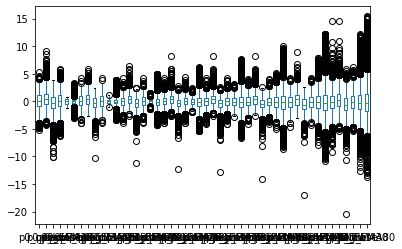

In [24]:
sampled_lookback_steps = np.linspace(0, max(lookback_steps), 8).astype(int)

get_by_lookback_steps(_df, sampled_lookback_steps).plot.box()

<AxesSubplot:>

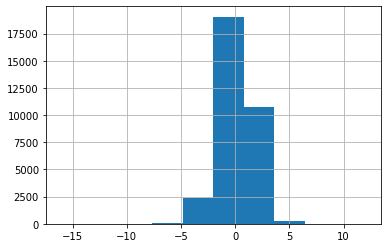

In [25]:
_df['norm_next_close'].hist()

<AxesSubplot:xlabel='p0_close', ylabel='norm_next_close'>

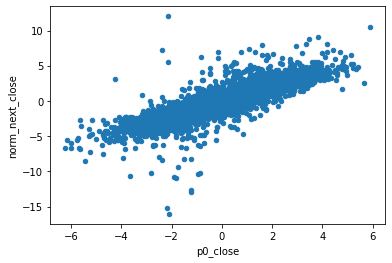

In [26]:
_df.plot(x='p0_close', y='norm_next_close', kind='scatter')

<AxesSubplot:>

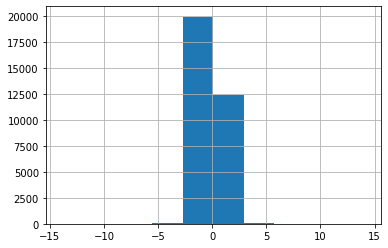

In [27]:
(_df['norm_next_close'] - _df['p0_close']).hist()

In [28]:
(_df['norm_next_close'] - _df['p0_close']).describe()

count    32505.000000
mean         0.003927
std          0.574494
min        -13.962827
25%         -0.217570
50%          0.005049
75%          0.228219
max         14.156852
dtype: float64

### Standardized Window Normalization 

In [29]:
class StandardizeWindowScaler:
    def fit(self, signal_df):
        signal_df = get_only_signal(df)
        means = {}
        stds = {}
        for column in SIGNAL_COLUMNS:
            means[column] = get_by_signal(df, column).mean(axis=1)
            stds[column] = get_by_signal(df, column).std(axis=1)
        self.means = pd.DataFrame(means)
        self.stds = pd.DataFrame(stds)
    def transform(self, signal_df):
        signal_df = signal_df.copy()
        for column in SIGNAL_COLUMNS:
            signal_column_df = get_by_signal(signal_df, column)
            signal_column_df = signal_column_df.subtract(self.means[column].to_numpy(), axis=0)
            signal_column_df = signal_column_df.divide(self.stds[column].to_numpy(), axis=0)
            signal_df[signal_column_df.columns] = signal_column_df.values
        return signal_df
    def fit_transform(self, signal_df):
        self.fit(signal_df)
        return self.transform(signal_df)
    def transform_target(self, target):
        return (target - self.means['close']) / self.stds['close']
    def inverse_transform_target(self, target):
        return target * self.stds['close'] + self.means['close']


In [30]:
_df = df.copy()
signal_df = get_only_signal(_df)

standardize_window_scaler = StandardizeWindowScaler()
_df[signal_df.columns] = standardize_window_scaler.fit_transform(signal_df)
_df['norm_next_close'] = standardize_window_scaler.transform_target(_df['next_close'])
_df

,base_volume,quote_volume,close,high,low,open,next_close,EMA30,EMA80,p0_open,...,p46_close,p46_EMA30,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,362.71000,1.214923e+05,334.17,346.52,328.68,346.52,334.94,311.443307,305.330403,3.517552,...,-1.072979,-0.600566,0.667001,-1.282317,-0.952028,-1.171995,-0.892898,-0.511128,0.868768,2.442189
2017-08-21 15:00:00,347.71000,1.160360e+05,334.94,338.34,329.47,334.17,338.33,312.959223,306.301209,2.386724,...,-0.606468,-0.605742,0.453183,-0.892898,-0.878442,-0.930722,-1.086822,-0.612361,0.533840,2.489455
2017-08-21 16:00:00,272.47000,9.125266e+04,338.33,338.34,333.25,334.94,332.33,314.596047,307.351333,2.257158,...,-0.528158,-0.597052,0.293969,-1.086822,-0.722167,-1.088881,-0.648970,-0.622086,0.341569,1.909634
2017-08-21 17:00:00,505.26000,1.704932e+05,332.33,342.72,330.80,338.33,316.82,315.740173,308.170306,2.301457,...,-0.670153,-0.612567,0.145078,-0.648970,-0.640727,-0.768732,-0.563247,-0.617745,0.203520,0.817043
2017-08-21 18:00:00,491.05000,1.606452e+05,316.82,333.63,316.82,332.33,329.71,315.809839,308.453903,1.798176,...,-0.885761,-0.658790,-0.003519,-0.563247,-0.672901,-0.587525,-0.696611,-0.636477,0.075929,1.598410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,3482.553027,3443.205732,1.146306,...,-1.262898,-2.328751,-2.002156,0.051313,-0.455684,-0.812437,-0.473041,-2.460928,-2.104545,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,3483.497993,3444.976036,0.803488,...,0.996289,-2.206222,-1.959681,-0.478540,-0.890917,-0.667659,-1.282518,-2.534106,-2.135892,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,3483.007155,3445.989609,0.415424,...,1.059053,-2.088142,-1.918599,-1.281500,0.687639,-0.549205,0.989230,-2.418966,-2.096565,-0.924808


### Apply normalization

In [31]:
scaler = StandardizeWindowScaler()

signal_df = get_only_signal(df)
signal_columns = list(signal_df.columns)
signal_df = signal_df[signal_columns]
df[signal_columns] = scaler.fit_transform(signal_df)
df['norm_next_close'] = scaler.transform_target(df['next_close'])
df

,base_volume,quote_volume,close,high,low,open,next_close,EMA30,EMA80,p0_open,...,p46_close,p46_EMA30,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80,norm_next_close
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,362.71000,1.214923e+05,334.17,346.52,328.68,346.52,334.94,311.443307,305.330403,3.517552,...,-1.072979,-0.600566,0.667001,-1.282317,-0.952028,-1.171995,-0.892898,-0.511128,0.868768,2.442189
2017-08-21 15:00:00,347.71000,1.160360e+05,334.94,338.34,329.47,334.17,338.33,312.959223,306.301209,2.386724,...,-0.606468,-0.605742,0.453183,-0.892898,-0.878442,-0.930722,-1.086822,-0.612361,0.533840,2.489455
2017-08-21 16:00:00,272.47000,9.125266e+04,338.33,338.34,333.25,334.94,332.33,314.596047,307.351333,2.257158,...,-0.528158,-0.597052,0.293969,-1.086822,-0.722167,-1.088881,-0.648970,-0.622086,0.341569,1.909634
2017-08-21 17:00:00,505.26000,1.704932e+05,332.33,342.72,330.80,338.33,316.82,315.740173,308.170306,2.301457,...,-0.670153,-0.612567,0.145078,-0.648970,-0.640727,-0.768732,-0.563247,-0.617745,0.203520,0.817043
2017-08-21 18:00:00,491.05000,1.606452e+05,316.82,333.63,316.82,332.33,329.71,315.809839,308.453903,1.798176,...,-0.885761,-0.658790,-0.003519,-0.563247,-0.672901,-0.587525,-0.696611,-0.636477,0.075929,1.598410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,3482.553027,3443.205732,1.146306,...,-1.262898,-2.328751,-2.002156,0.051313,-0.455684,-0.812437,-0.473041,-2.460928,-2.104545,0.434719
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,3483.497993,3444.976036,0.803488,...,0.996289,-2.206222,-1.959681,-0.478540,-0.890917,-0.667659,-1.282518,-2.534106,-2.135892,-0.094920
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,3483.007155,3445.989609,0.415424,...,1.059053,-2.088142,-1.918599,-1.281500,0.687639,-0.549205,0.989230,-2.418966,-2.096565,-0.924808


## Select input / target columns

In [38]:
selected_columns = []
selected_columns += signal_columns
selected_columns

['p0_open',
 'p0_high',
 'p0_low',
 'p0_close',
 'p0_EMA30',
 'p0_EMA80',
 'p1_open',
 'p1_high',
 'p1_low',
 'p1_close',
 'p1_EMA30',
 'p1_EMA80',
 'p2_open',
 'p2_high',
 'p2_low',
 'p2_close',
 'p2_EMA30',
 'p2_EMA80',
 'p3_open',
 'p3_high',
 'p3_low',
 'p3_close',
 'p3_EMA30',
 'p3_EMA80',
 'p4_open',
 'p4_high',
 'p4_low',
 'p4_close',
 'p4_EMA30',
 'p4_EMA80',
 'p5_open',
 'p5_high',
 'p5_low',
 'p5_close',
 'p5_EMA30',
 'p5_EMA80',
 'p6_open',
 'p6_high',
 'p6_low',
 'p6_close',
 'p6_EMA30',
 'p6_EMA80',
 'p7_open',
 'p7_high',
 'p7_low',
 'p7_close',
 'p7_EMA30',
 'p7_EMA80',
 'p8_open',
 'p8_high',
 'p8_low',
 'p8_close',
 'p8_EMA30',
 'p8_EMA80',
 'p9_open',
 'p9_high',
 'p9_low',
 'p9_close',
 'p9_EMA30',
 'p9_EMA80',
 'p10_open',
 'p10_high',
 'p10_low',
 'p10_close',
 'p10_EMA30',
 'p10_EMA80',
 'p11_open',
 'p11_high',
 'p11_low',
 'p11_close',
 'p11_EMA30',
 'p11_EMA80',
 'p12_open',
 'p12_high',
 'p12_low',
 'p12_close',
 'p12_EMA30',
 'p12_EMA80',
 'p13_open',
 'p13_h

In [39]:
target_column = 'norm_next_close'
target_column

'norm_next_close'

# Train validation test split

In [40]:
train_df = df.loc[: '2020-11-01']
val_df = df.loc['2020-11-01': '2021-02-01']
test_df = df.loc['2021-02-01': ]
print('train', len(train_df))
print('val', len(val_df))
print('test', len(test_df))

train 28036
val 2224
test 2293


# Model building

In [41]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
def post_process(y):
    y = scaler.inverse_transform_target(y)
    return y

In [43]:
model = lgb.LGBMRegressor(max_depth=8,
                          boosting_type='goss',
                          learning_rate=0.025,
                          num_leaves=50,
                          n_estimators=64,
                          bagging_fraction=0.8,
                          sub_feature=0.8,
                          metric='mse',
                          feature_fraction_seed=41,
                          bagging_seed=42
                          )
model.fit(train_df[selected_columns], train_df[target_column],
          eval_metric='rmse',
          eval_names=['train', 'val'],
          eval_set=[(train_df[selected_columns], train_df[target_column]),
                    (val_df[selected_columns], val_df[target_column])],
          verbose=True,
          sample_weight=np.linspace(50, 100, len(train_df)),
          early_stopping_rounds=30
          )

[1]	train's rmse: 1.49672	train's l2: 2.24018	val's rmse: 1.44949	val's l2: 2.10103
Training until validation scores don't improve for 30 rounds
[2]	train's rmse: 1.46495	train's l2: 2.14608	val's rmse: 1.41772	val's l2: 2.00992
[3]	train's rmse: 1.43406	train's l2: 2.05653	val's rmse: 1.38682	val's l2: 1.92326
[4]	train's rmse: 1.40408	train's l2: 1.97145	val's rmse: 1.3569	val's l2: 1.84117
[5]	train's rmse: 1.37496	train's l2: 1.89052	val's rmse: 1.32769	val's l2: 1.76277
[6]	train's rmse: 1.3467	train's l2: 1.81359	val's rmse: 1.29959	val's l2: 1.68893
[7]	train's rmse: 1.31924	train's l2: 1.7404	val's rmse: 1.27233	val's l2: 1.61882
[8]	train's rmse: 1.2926	train's l2: 1.67081	val's rmse: 1.24572	val's l2: 1.55181
[9]	train's rmse: 1.26674	train's l2: 1.60462	val's rmse: 1.21986	val's l2: 1.48807
[10]	train's rmse: 1.243	train's l2: 1.54505	val's rmse: 1.19632	val's l2: 1.43118
[11]	train's rmse: 1.21863	train's l2: 1.48505	val's rmse: 1.17199	val's l2: 1.37355
[12]	train's rmse: 

LGBMRegressor(bagging_fraction=0.8, bagging_seed=42, boosting_type='goss',
              feature_fraction_seed=41, learning_rate=0.025, max_depth=8,
              metric='mse', n_estimators=64, num_leaves=50, sub_feature=0.8)

In [44]:

prediction = model.predict(df[selected_columns])
df['norm_prediction'] = prediction
df['prediction'] = post_process(prediction)
df

,base_volume,quote_volume,close,high,low,open,next_close,EMA30,EMA80,p0_open,...,p46_EMA80,p47_open,p47_high,p47_low,p47_close,p47_EMA30,p47_EMA80,norm_next_close,norm_prediction,prediction
time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 14:00:00,362.71000,1.214923e+05,334.17,346.52,328.68,346.52,334.94,311.443307,305.330403,3.517552,...,0.667001,-1.282317,-0.952028,-1.171995,-0.892898,-0.511128,0.868768,2.442189,1.995526,328.739116
2017-08-21 15:00:00,347.71000,1.160360e+05,334.94,338.34,329.47,334.17,338.33,312.959223,306.301209,2.386724,...,0.453183,-0.892898,-0.878442,-0.930722,-1.086822,-0.612361,0.533840,2.489455,1.926293,330.111561
2017-08-21 16:00:00,272.47000,9.125266e+04,338.33,338.34,333.25,334.94,332.33,314.596047,307.351333,2.257158,...,0.293969,-1.086822,-0.722167,-1.088881,-0.648970,-0.622086,0.341569,1.909634,1.892343,332.065233
2017-08-21 17:00:00,505.26000,1.704932e+05,332.33,342.72,330.80,338.33,316.82,315.740173,308.170306,2.301457,...,0.145078,-0.648970,-0.640727,-0.768732,-0.563247,-0.617745,0.203520,0.817043,1.559162,328.551605
2017-08-21 18:00:00,491.05000,1.606452e+05,316.82,333.63,316.82,332.33,329.71,315.809839,308.453903,1.798176,...,-0.003519,-0.563247,-0.672901,-0.587525,-0.696611,-0.636477,0.075929,1.598410,0.791164,316.906737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 19:00:00,22844.22755,8.026408e+07,3512.59,3533.76,3498.28,3525.90,3497.20,3482.553027,3443.205732,1.146306,...,-2.002156,0.051313,-0.455684,-0.812437,-0.473041,-2.460928,-2.104545,0.434719,0.666156,3506.857677
2021-05-07 20:00:00,18632.39404,6.533341e+07,3497.20,3525.62,3476.04,3512.59,3475.89,3483.497993,3444.976036,0.803488,...,-1.959681,-0.478540,-0.890917,-0.667659,-1.282518,-2.534106,-2.135892,-0.094920,0.398628,3496.473924
2021-05-07 21:00:00,21439.49414,7.456822e+07,3475.89,3497.80,3455.70,3497.17,3443.00,3483.007155,3445.989609,0.415424,...,-1.918599,-1.281500,0.687639,-0.549205,0.989230,-2.418966,-2.096565,-0.924808,-0.058805,3478.471921


<AxesSubplot:>

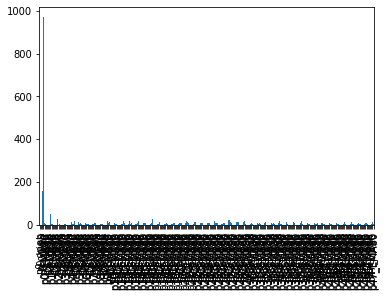

In [45]:
pd.Series(model.feature_importances_, index=selected_columns).plot(kind='bar')

In [46]:
train_df = df.loc[: '2020-11-01']
val_df = df.loc['2020-11-01': '2021-02-01']
test_df = df.loc['2021-02-01': ]
print('train', len(train_df))
print('val', len(val_df))
print('test', len(test_df))

train 28036
val 2224
test 2293


In [47]:
train_mae = mean_absolute_error(train_df['next_close'], train_df['prediction'])
val_mae = mean_absolute_error(val_df['next_close'], val_df['prediction'])
test_mae = mean_absolute_error(test_df['next_close'], test_df['prediction'])

print('train mae', train_mae)
print('val mae', val_mae)
print('test mae', test_mae)

train mae 3.120485282843509
val mae 8.94784579162816
test mae 18.739815954995834


In [34]:
train_rmse = mean_squared_error(train_df['next_close'], train_df['prediction'], squared=False)
val_rmse = mean_squared_error(val_df['next_close'], val_df['prediction'], squared=False)
test_rmse = mean_squared_error(test_df['next_close'], test_df['prediction'], squared=False)

print('train rmse', train_rmse)
print('val rmse', val_rmse)
print('test rmse', test_rmse)

train rmse 6.919259844384478
val rmse 15.055030189468821
test rmse 27.086546889280925


<AxesSubplot:title={'center':'ETH/USDT Test set'}, xlabel='time'>

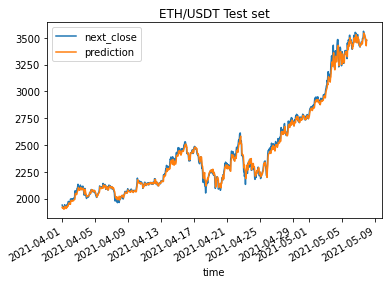

In [48]:
df.loc['2021-04-01':].plot(y=['next_close', 'prediction'], title='ETH/USDT Test set')

<AxesSubplot:title={'center':'ETH/USDT Test set'}, xlabel='time'>

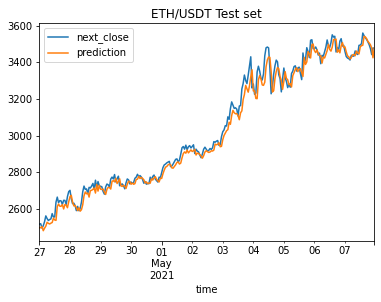

In [49]:
df.loc['2021-04-27':].plot(y=['next_close', 'prediction'], title='ETH/USDT Test set')

In [52]:
%matplotlib widget
sns.histplot(data=df, x="norm_next_close", color="skyblue", label="Norm next_close", kde=True)
sns.histplot(data=df, x="norm_prediction", color="red", label="Norm Predicition", kde=True)

plt.legend() 
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
last_close_diff = df['norm_next_close'] - df['p0_close']
print(last_close_diff.describe())
last_close_diff.hist()

count    32505.000000
mean         0.003927
std          0.574494
min        -13.962827
25%         -0.217570
50%          0.005049
75%          0.228219
max         14.156852
dtype: float64


<AxesSubplot:xlabel='norm_next_close', ylabel='Count'>

In [54]:
last_close_diff = df['norm_prediction'] - df['p0_close']
print(last_close_diff.describe())
last_close_diff.hist()

count    32505.000000
mean        -0.006596
std          0.268589
min         -2.274570
25%         -0.207166
50%         -0.010582
75%          0.178696
max          2.775227
dtype: float64


<AxesSubplot:xlabel='norm_next_close', ylabel='Count'>

In [55]:
%matplotlib widget

sns.histplot(data=df['norm_next_close'] - df['p0_close'], color="skyblue", label="next_close", kde=True)
sns.histplot(data=df['norm_prediction'] - df['p0_close'], color="red", label="predicition", kde=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:ylabel='Count'>

In [56]:
df.plot(x='p0_close', y='norm_prediction', kind='scatter')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='p0_close', ylabel='norm_prediction'>

In [57]:
%matplotlib widget
sns.histplot(data=df, x="next_close", color="skyblue", label="next_close", kde=True)
sns.histplot(data=df, x="prediction", color="red", label="predicition", kde=True)

plt.legend() 
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
lgb.plot_tree(model, figsize=(24, 24))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

# Export model

In [ ]:
with open('bin/lightgbm_regression_h1-window48.pickle', 'wb') as f:
    pickle.dump(model, f)